# Customer Churn Prediction Model

This is the continuation of project and in this notebook we are going train the model for prediction. 

## Importing the necessary Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset

In [43]:
df = pd.read_csv('cleaned_data.csv')

In [44]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Transaction_Status'],
      dtype='str')

In [ ]:
from scipy.stats import linregress
from datetime import timedelta

def feature_engineering(df):


    df = df.copy()
    

    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    

    df['Total_Spend'] = df['Quantity'] * df['Price']
    

    max_date = df['InvoiceDate'].max()
    snapshot_date = max_date - timedelta(days=180)
    churn_window_end = snapshot_date + timedelta(days=90)

    df = df[df['InvoiceDate'] <= snapshot_date]

    last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
    last_purchase['Churn'] = ((snapshot_date - last_purchase['InvoiceDate']).dt.days > 90).astype(int)

    rfm = df.groupby('Customer ID').agg(Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
                                        Frequency=('Invoice', 'nunique'),
                                        Monetary=('Total_Spend', 'sum'),
                                        Total_Products_Purchased=('Quantity', 'sum'),
                                        Unique_Products_Purchased=('StockCode', 'nunique')).reset_index()
    

    rfm['Avg_Transaction_Value'] = rfm['Monetary'] / rfm['Frequency']

    product_features = df.groupby('Customer ID').agg(Top_Product_Concentration=('StockCode', lambda x: x.value_counts().iloc[0] / len(x)),Category_Diversity=('Description', 'nunique')).reset_index()
    
    df['Quarter'] = df['InvoiceDate'].dt.to_period('Q')
    quarterly = df.groupby(['Customer ID', 'Quarter'])['Total_Spend'].sum().reset_index()
    quarterly_growth = quarterly.groupby('Customer ID').apply(lambda x: linregress(np.arange(len(x)), x['Total_Spend'].values).slope if len(x) > 1 else 0).reset_index(name='Quarterly_Spending_Trend')


    tenure = df.groupby('Customer ID')['InvoiceDate'].min().reset_index(name='First_Purchase')
    tenure['Customer_Tenure_Days'] = (snapshot_date - tenure['First_Purchase']).dt.days
    rfm = rfm.merge(tenure[['Customer ID', 'Customer_Tenure_Days']], on='Customer ID', how='left')
    
    purchase_gaps = df.sort_values(['Customer ID', 'InvoiceDate']).groupby('Customer ID')['InvoiceDate'].diff().dt.days
    gap_stats = purchase_gaps.groupby(df['Customer ID']).agg( Avg_Days_Between_Purchases='mean',Std_Days_Between_Purchases='std' ).reset_index()
    gap_stats['Std_Days_Between_Purchases'] = gap_stats['Std_Days_Between_Purchases'].fillna(0)
    

    gap_stats['Purchase_Regularity'] = (gap_stats['Avg_Days_Between_Purchases'] / (gap_stats['Std_Days_Between_Purchases'] + 1)).fillna(0)



    monthly = df.assign(YearMonth=df['InvoiceDate'].dt.to_period('M')).groupby(['Customer ID', 'YearMonth'])['Total_Spend'].sum().reset_index()
    

    def calc_slope(s):
        return 0 if len(s) <= 1 else linregress(np.arange(len(s)), s.values).slope
    
    trend = monthly.groupby('Customer ID')['Total_Spend'].apply(calc_slope).reset_index(name='Spending_Trend')
    

    rfm['Revenue_Per_Product'] = (rfm['Monetary'] / rfm['Unique_Products_Purchased']).fillna(0)
    

    total_tx = df.groupby('Customer ID')['Invoice'].nunique().reset_index(name='Total_Transactions')
    cancelled = df[df['Transaction_Status']=='Cancelled'].groupby('Customer ID')['Invoice'].nunique().reset_index(name='Cancelled_Transactions')
    cancel_features = total_tx.merge(cancelled, on='Customer ID', how='left')
    cancel_features['Cancelled_Transactions'] = cancel_features['Cancelled_Transactions'].fillna(0)
    cancel_features['Cancellation_Rate'] = cancel_features['Cancelled_Transactions'] / cancel_features['Total_Transactions']

    price_behavior = df.groupby('Customer ID').agg(Price_Sensitivity=('Price', 'std')).reset_index()
    
    country_mode = df.groupby(['Customer ID','Country']).size().reset_index(name='Count').sort_values('Count', ascending=False).drop_duplicates('Customer ID')
    country_mode['Is_UK'] = (country_mode['Country'] == 'United Kingdom').astype(int)

    repeat_customers = df.groupby('Customer ID')['Invoice'].nunique().reset_index(name='Invoice_Count')
    repeat_customers['Is_Repeat_Customer'] = (repeat_customers['Invoice_Count'] >= 2).astype(int)
    
 
    customer_data = rfm.merge(gap_stats[['Customer ID','Avg_Days_Between_Purchases','Purchase_Regularity']], on='Customer ID', how='left')
    customer_data = customer_data.merge(product_features, on='Customer ID', how='left')
    customer_data = customer_data.merge(quarterly_growth, on='Customer ID', how='left')
    customer_data = customer_data.merge(price_behavior, on='Customer ID', how='left')   
    customer_data = customer_data.merge(trend, on='Customer ID', how='left')
    customer_data = customer_data.merge(cancel_features[['Customer ID','Cancellation_Rate']], on='Customer ID', how='left')
    customer_data = customer_data.merge(country_mode[['Customer ID','Is_UK']], on='Customer ID', how='left')
    customer_data = customer_data.merge(last_purchase[['Customer ID','Churn']], on='Customer ID', how='left')

  
    numeric_cols = customer_data.select_dtypes(include=['number']).columns
    customer_data[numeric_cols] = customer_data[numeric_cols].fillna(0)

    return customer_data

In [50]:
customer_data = feature_engineering(df)
customer_data.head()

KeyError: 'Avg_Days_Between_Purchases'

In [ ]:
customer_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,5875.0,15321.350128,1714.611499,12346.00,13839.500000,15322.000000,16804.500000,18287.000000
Recency,5875.0,198.482383,209.382117,0.00,23.500000,93.000000,377.000000,738.000000
Frequency,5875.0,7.467574,15.371922,1.00,2.000000,4.000000,8.000000,466.000000
Monetary,5875.0,2784.238730,13799.297001,-1343.24,327.800000,835.220000,2164.280000,578408.640000
Total_Products_Purchased,5875.0,1707.976000,8530.025201,-1086.00,182.000000,472.000000,1328.000000,364956.000000
Unique_Products_Purchased,5875.0,82.021617,116.570368,1.00,19.000000,45.000000,103.000000,2551.000000
Avg_Transaction_Value,5875.0,307.291767,409.977961,-658.63,150.696471,228.945000,354.114722,11880.840000
Customer_Tenure_Days,5875.0,475.803404,224.318926,0.00,315.000000,533.000000,672.000000,738.000000
Revenue_Per_Product,5875.0,54.683352,553.429965,-54.00,13.259343,19.143902,30.661380,39619.500000
Avg_Days_Between_Purchases,5875.0,5.213330,18.342425,0.00,0.000000,1.892086,4.798810,596.000000


We can see that we have many negative values and this is indicating there will be some outlier which we need to handle it properly. 

## Outlier Detection and Removal 

Usually in churn detection extreme values often represent high-value customers rather than noise. Normally used outlier removal would disproportionately eliminate VIP customers and bias churn modeling. Its recommend to capped extreme values and applied log transformations to preserve business signal. In our analysis also we have seen that there are VIP customers who are inactive after 1 or 2 purchases. Let's visualize the numeric feature and see. 

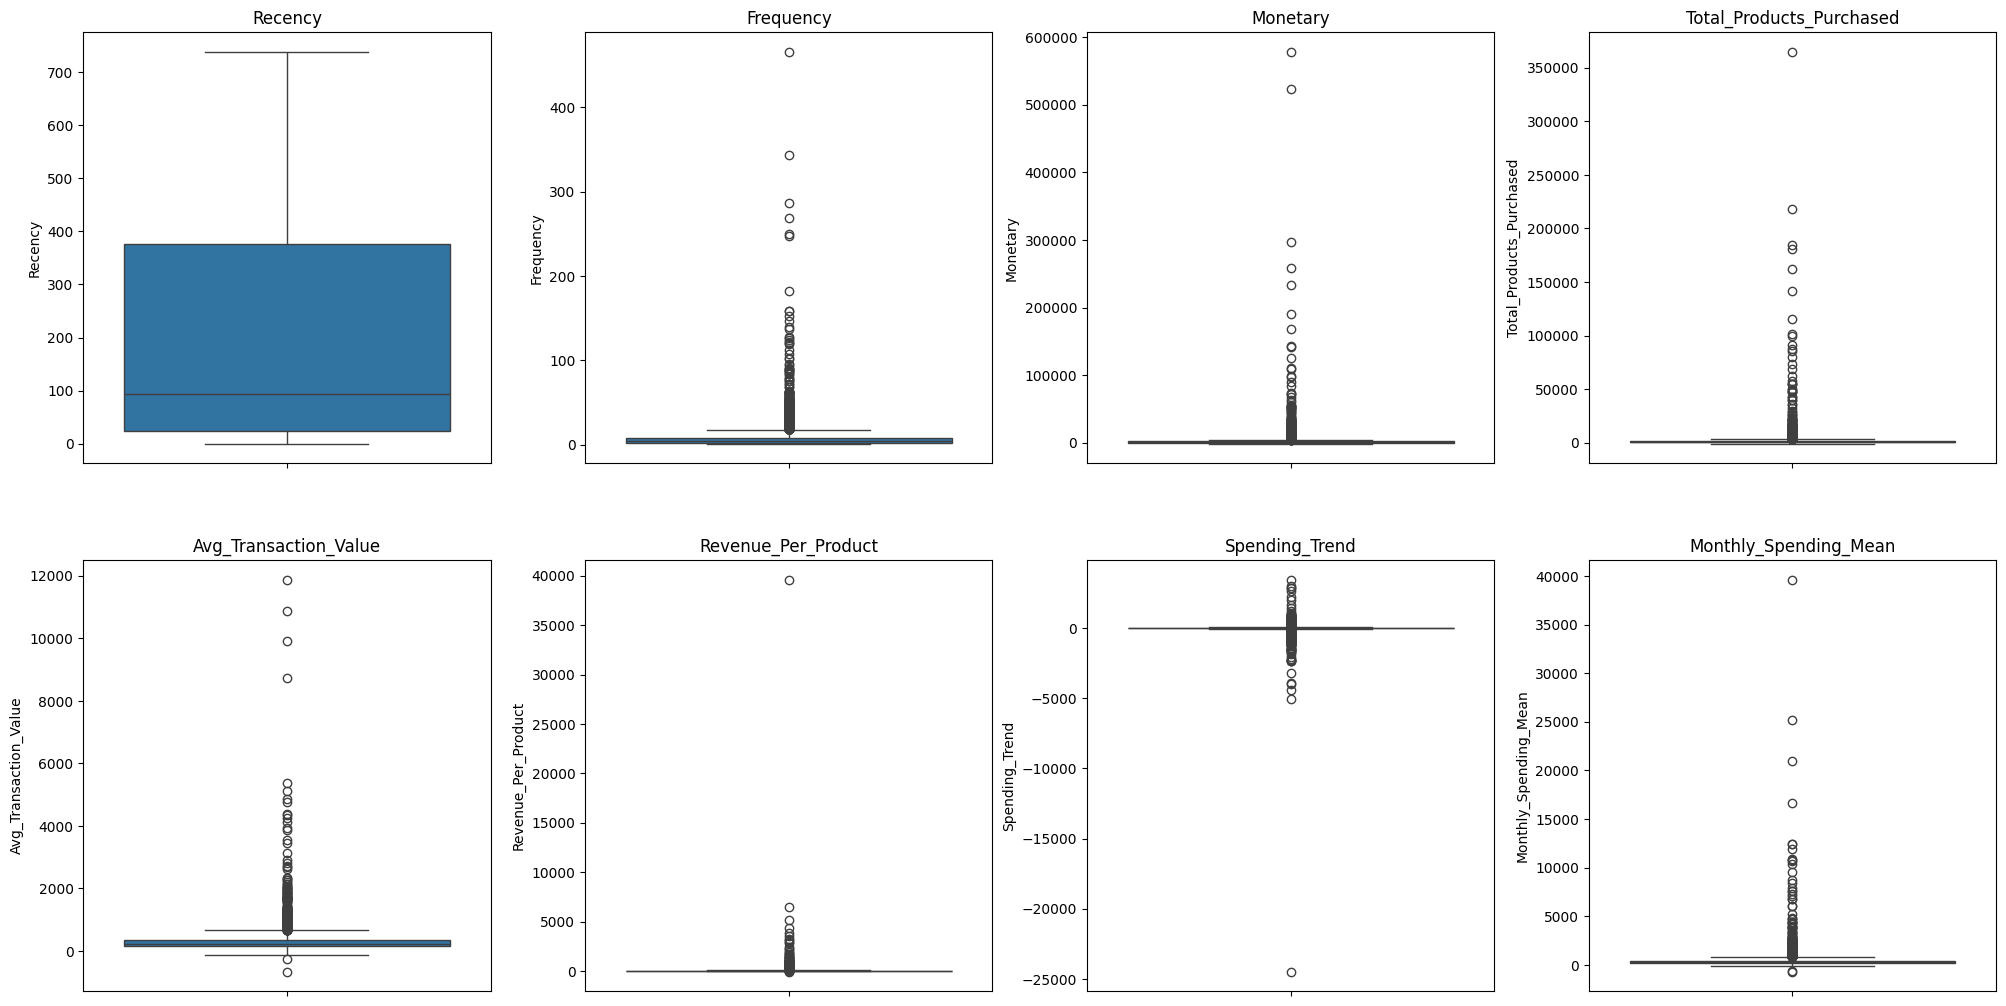

In [4]:
selected_cols = df[['Recency', 'Frequency', 'Monetary', 'Total_Products_Purchased', 'Avg_Transaction_Value', 'Revenue_Per_Product','Spending_Trend', 'Monthly_Spending_Mean']]

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
ax = ax.flatten()

index = 0
for col in selected_cols.columns:
    sns.boxplot(y=col, data=selected_cols, ax=ax[index])
    ax[index].set_title(f"{col}")
    index += 1


for j in range(index, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

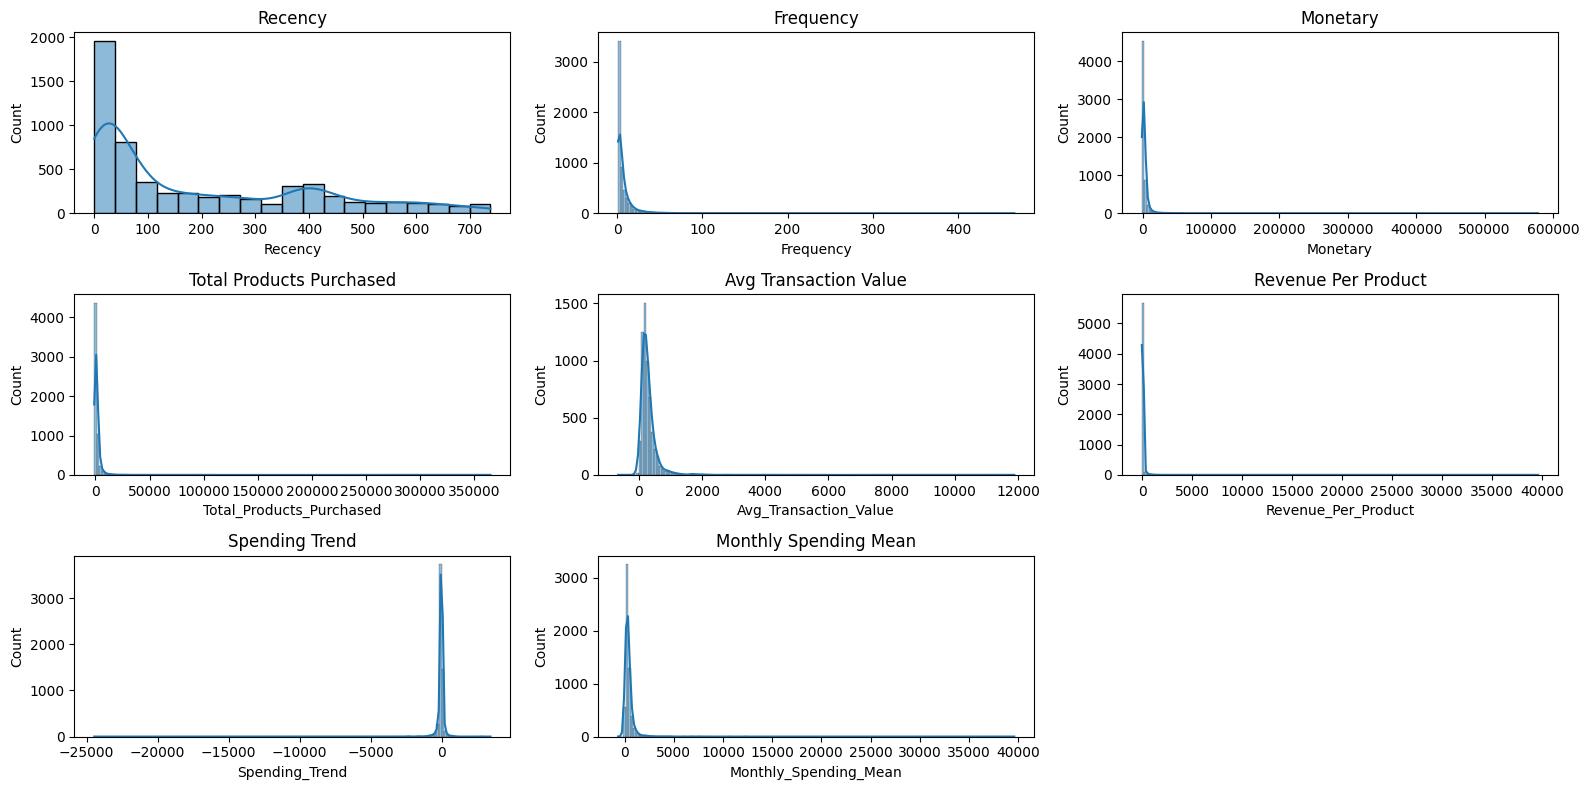

In [5]:
plt.figure(figsize=(16, 8))



plt.subplot(3, 3, 1)
sns.histplot(df['Recency'], kde=True)
plt.title('Recency')

plt.subplot(3, 3, 2)
sns.histplot(df['Frequency'], kde=True)
plt.title('Frequency')

plt.subplot(3, 3, 3)
sns.histplot(df['Monetary'], kde=True)
plt.title('Monetary')

plt.subplot(3, 3, 4)
sns.histplot(df['Total_Products_Purchased'], kde=True)
plt.title('Total Products Purchased')

plt.subplot(3, 3, 5)
sns.histplot(df['Avg_Transaction_Value'], kde=True)
plt.title('Avg Transaction Value')

plt.subplot(3, 3, 6)
sns.histplot(df['Revenue_Per_Product'], kde=True)
plt.title('Revenue Per Product')

plt.subplot(3, 3, 7)
sns.histplot(df['Spending_Trend'], kde=True)
plt.title('Spending Trend')

plt.subplot(3, 3, 8)
sns.histplot(df['Monthly_Spending_Mean'], kde=True)
plt.title('Monthly Spending Mean')

plt.tight_layout()
plt.show()

As per our analysis it was found that the Top 10 % customers contribute to the 50 % revenue and outliers which we are seeing is not error its insights of the business. So removing outliers is not recommended. Let's just handle the negative values only. 

In [6]:
negative_columns = ['Monetary', 'Avg_Transaction_Value', 'Spending_Trend', 'Revenue_Per_Product', 'Monthly_Spending_Mean']

negative_summary = {}

for col in negative_columns:
    negative_count = (df[col] < 0).sum()
    negative_percentage = (negative_count / len(df)) * 100
    
    if negative_count > 0:
        negative_values = df[df[col] < 0][col]
        negative_summary[col] = {
            'count': negative_count,
            'percentage': negative_percentage,
            'min_value': negative_values.min(),
            'max_value': negative_values.max(),
            'mean_value': negative_values.mean()
        }

print("\nNegative Values Found:\n")
for col, stats in negative_summary.items():
    print(f"{col}:")
    print(f"  Count: {stats['count']} ({stats['percentage']:.2f}%)")
    print(f"  Range: {stats['min_value']:.2f} to {stats['max_value']:.2f}")
    print(f"  Mean: {stats['mean_value']:.2f}\n")


Negative Values Found:

Monetary:
  Count: 27 (0.46%)
  Range: -1343.24 to -0.00
  Mean: -109.47

Avg_Transaction_Value:
  Count: 27 (0.46%)
  Range: -658.63 to -0.00
  Mean: -61.08

Spending_Trend:
  Count: 2413 (41.07%)
  Range: -24460.90 to -0.04
  Mean: -140.90

Revenue_Per_Product:
  Count: 27 (0.46%)
  Range: -54.00 to -0.00
  Mean: -14.93

Monthly_Spending_Mean:
  Count: 26 (0.44%)
  Range: -671.62 to -1.25
  Mean: -79.21



All the negative values are contributed by Monetary feature due to cancellations or refund. We can just filter out  and clean the data.

In [7]:
df_clean = df[df['Monetary'] >= 0].copy()

This removes only 27 customers but keeps all 2,413 declining spending signals

In [8]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,5848.0,15320.549761,1714.945664,12346.0,13838.750000,15321.500000,16803.250000,18287.000000
Recency,5848.0,196.655438,207.752108,0.0,23.000000,91.000000,375.000000,738.000000
Frequency,5848.0,7.495725,15.401662,1.0,2.000000,4.000000,8.000000,466.000000
Monetary,5848.0,2797.598859,13829.704248,0.0,331.327500,841.190000,2172.375000,578408.640000
Total_Products_Purchased,5848.0,1716.174248,8548.829385,0.0,184.750000,476.500000,1333.000000,364956.000000
Unique_Products_Purchased,5848.0,82.369528,116.723263,1.0,19.000000,45.000000,103.250000,2551.000000
Avg_Transaction_Value,5848.0,308.992547,410.062793,0.0,151.586250,229.770000,355.363750,11880.840000
Customer_Tenure_Days,5848.0,474.996751,224.358594,0.0,312.000000,531.500000,670.000000,738.000000
Revenue_Per_Product,5848.0,55.004744,554.685357,0.0,13.443990,19.199186,30.744456,39619.500000
Avg_Days_Between_Purchases,5848.0,5.223069,18.373028,0.0,0.000000,1.906878,4.807186,596.000000


In [9]:
df_clean.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary',
       'Total_Products_Purchased', 'Unique_Products_Purchased',
       'First_Purchase', 'Last_Purchase', 'Avg_Transaction_Value',
       'Customer_Tenure_Days', 'Revenue_Per_Product',
       'Avg_Days_Between_Purchases', 'Std_Days_Between_Purchases',
       'Purchase_Regularity', 'Spending_Trend', 'Monthly_Spending_Mean',
       'Monthly_Spending_Std', 'Cancellation_Rate', 'Is_UK',
       'Revenue_Percentile', 'R_Score', 'F_Score', 'M_Score', 'RFM_Segment'],
      dtype='str')

In [10]:
from datetime import timedelta

df_clean['Last_Purchase'] = pd.to_datetime(df_clean['Last_Purchase'])

max_date = df_clean['Last_Purchase'].max()
snapshot_date = max_date - timedelta(days=180)
churn_window_end = snapshot_date + timedelta(days=90)

df_clean['Churn'] = (df_clean['Last_Purchase'] < snapshot_date - timedelta(days=90)).astype(int)




columns_to_remove = [
    'Customer ID',                  
    'First_Purchase',               
    'Last_Purchase',              
    'Std_Days_Between_Purchases',   
    'Monthly_Spending_Std',         
    'Revenue_Percentile',           
    'R_Score',                      
    'F_Score',                      
    'M_Score',                      
    'RFM_Segment'                   
]

columns_to_remove = [col for col in columns_to_remove if col in df_clean.columns]

df_clean = df_clean.drop(columns=columns_to_remove)

In [11]:
df_clean.info()

<class 'pandas.DataFrame'>
Index: 5848 entries, 0 to 5874
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Recency                     5848 non-null   int64  
 1   Frequency                   5848 non-null   int64  
 2   Monetary                    5848 non-null   float64
 3   Total_Products_Purchased    5848 non-null   int64  
 4   Unique_Products_Purchased   5848 non-null   int64  
 5   Avg_Transaction_Value       5848 non-null   float64
 6   Customer_Tenure_Days        5848 non-null   int64  
 7   Revenue_Per_Product         5848 non-null   float64
 8   Avg_Days_Between_Purchases  5848 non-null   float64
 9   Purchase_Regularity         5848 non-null   float64
 10  Spending_Trend              5848 non-null   float64
 11  Monthly_Spending_Mean       5848 non-null   float64
 12  Cancellation_Rate           5848 non-null   float64
 13  Is_UK                       5848 non-null   int64

In [12]:
df_clean['Churn'].value_counts(normalize=True) * 100

Churn
0    67.800958
1    32.199042
Name: proportion, dtype: float64

In [13]:
df_clean.head()

,Recency,Frequency,Monetary,Total_Products_Purchased,Unique_Products_Purchased,Avg_Transaction_Value,Customer_Tenure_Days,Revenue_Per_Product,Avg_Days_Between_Purchases,Purchase_Regularity,Spending_Trend,Monthly_Spending_Mean,Cancellation_Rate,Is_UK,Churn
0,325,4,169.36,24,25,42.34000,646,6.774400,12.840000,0.272595,-13.525000,56.453333,0.25,1,1
1,1,8,4921.53,2967,126,615.19125,403,39.059762,1.805430,0.157167,3.339405,615.191250,0.00,0,0
2,74,5,1658.40,2704,24,331.68000,437,69.100000,8.044444,0.258747,-22.812000,331.680000,0.00,0,0
3,18,4,3654.54,1616,138,913.63500,735,26.482174,4.068182,0.116182,452.920000,913.635000,0.25,0,0
4,309,1,294.40,196,16,294.40000,309,18.400000,0.000000,0.000000,0.000000,294.400000,0.00,0,1


We now have clean dataset and all the features are numeric so we don't need to do any other transformation. We shall not split the data. 

## Train - Test Split 

In [14]:
from sklearn.model_selection import train_test_split
y = df_clean['Churn']
X = df_clean.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


## Standard Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)

0.8134333449923202

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_scaled)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       793
           1       1.00      0.97      0.98       377

    accuracy                           0.99      1170
   macro avg       0.99      0.98      0.99      1170
weighted avg       0.99      0.99      0.99      1170



In [20]:
import xgboost as xgb
model2 = xgb.XGBClassifier()
model2.fit(X_train_scaled, y_train)
model2.score(X_test_scaled, y_test)

0.9991452991452991

In [21]:
y_pred = model2.predict(X_test_scaled)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       1.00      1.00      1.00       377

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170



In [22]:
df_clean.groupby('Churn')['Recency'].min()

Churn
0      0
1    270
Name: Recency, dtype: int64